<center> Predicting Cryptocurrency Prices using Long Short-Term Memory <center>

In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.layers import Activation, Dense, Dropout, LSTM
from keras.models import Sequential

##### Predicting Bitcoin Prices

In [12]:
# Loading Bitcoin prices into a dataframe

data = pd.read_csv('BTC-USD.csv')
data.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-10-01,10795.254883,10933.624023,10472.356445,10619.452148,10619.452148,40023134100
1,2020-10-02,10619.821289,10657.837891,10416.689453,10575.974609,10575.974609,48661453918
2,2020-10-03,10575.100586,10598.940430,10511.129883,10549.329102,10549.329102,44660271563
3,2020-10-04,10550.440430,10686.000000,10534.391602,10669.583008,10669.583008,71251776995
4,2020-10-05,10676.529297,10793.507813,10634.600586,10793.339844,10793.339844,47537578009


In [16]:
# Close data of Bitcoin is what we will focus on
close_data = data[['Date', 'Close']]
close_data.head(5)

,Date,Close
0,2020-10-01,10619.452148
1,2020-10-02,10575.974609
2,2020-10-03,10549.329102
3,2020-10-04,10669.583008
4,2020-10-05,10793.339844


In [20]:
# Deleting date column and normalizing using MinMax Scaler
from sklearn.preprocessing import MinMaxScaler
close_data = data[['Close']]
scaler=MinMaxScaler(feature_range=(0,1))
close_data=scaler.fit_transform(np.array(close_data).reshape(-1,1))
print(close_data.shape)

(731, 1)


In [21]:
# Training set is 60% and 40% testing set

training_size=int(len(close_data)*0.60)
test_size=len(close_data)-training_size
train_data,test_data=close_data[0:training_size,:],close_data[training_size:len(close_data),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (438, 1)
test_data:  (293, 1)


#### Time-series analysis

In [23]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [24]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (422, 15)
y_train:  (422,)
X_test:  (277, 15)
y_test (277,)


In [26]:
# reshape input to be [samples, time steps, features] for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (422, 15, 1)
X_test:  (277, 15, 1)


In [27]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [28]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
14/14 [==============================] - 6s 118ms/step - loss: 0.1930 - val_loss: 0.0492
Epoch 2/200
14/14 [==============================] - 0s 26ms/step - loss: 0.0544 - val_loss: 0.0077
Epoch 3/200
14/14 [==============================] - 0s 33ms/step - loss: 0.0083 - val_loss: 0.0019
Epoch 4/200
14/14 [==============================] - 0s 26ms/step - loss: 0.0074 - val_loss: 0.0018
Epoch 5/200
14/14 [==============================] - 1s 40ms/step - loss: 0.0052 - val_loss: 0.0020
Epoch 6/200
14/14 [==============================] - 0s 27ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 7/200
14/14 [==============================] - 1s 38ms/step - loss: 0.0046 - val_loss: 0.0019
Epoch 8/200
14/14 [==============================] - 0s 27ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 9/200
14/14 [==============================] - 1s 40ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 10/200
14/14 [==============================] - 0s 26ms/step - loss: 0.0041 - val_loss: 0.002

#### Loss vs Validation Loss

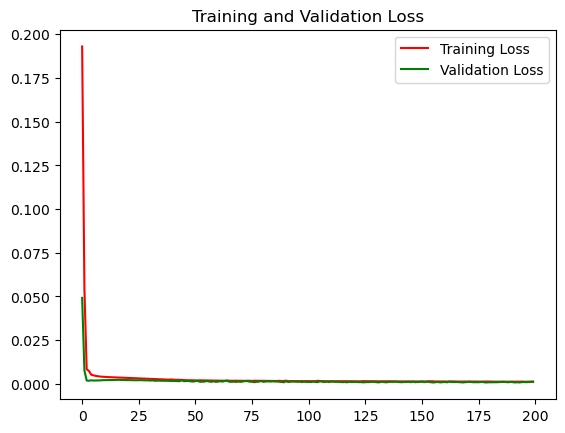

<Figure size 640x480 with 0 Axes>

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [30]:
# Prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

9/9 [==============================] - 0s 5ms/step


((422, 1), (277, 1))

In [33]:
# Transformation to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1)) 
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1)) 

In [34]:
# Evaluation metrices RMSE and MAE
import math 
from sklearn.metrics import mean_squared_error
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  2041.8327114614842
Train data MSE:  4169080.821594157
Train data MAE:  1515.902572839899
-------------------------------------------------------------------------------------
Test data RMSE:  1908.5690382937257
Test data MSE:  3642635.773933437
Test data MAE:  1532.5640300185019


In [35]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
         #print(temp_input)
       
        lst_output.extend(yhat.tolist())
        i=i+1
        
    else:
        
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        
        lst_output.extend(yhat.tolist())
        i=i+1
               
print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


In [36]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [42]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(close_data[len(close_data)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])
fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'], new_pred_plot['next_predicted_days_value']], labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days', plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [43]:
lstm_data=close_data.tolist()
lstm_data.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstm_data=scaler.inverse_transform(lstm_data).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstm_data,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()